In [180]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

%matplotlib inline 

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (15,7)

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Harold\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [162]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [137]:
df = pd.read_pickle("sanitized_df")

# extracting polarity score
df['compound'] = df.quotation.apply(lambda x: sia.polarity_scores(x)['compound'])

# building granualrity on the time to be able to extract trend

df['year'] = df.date.dt.year
df.year = df.year.astype("category")

df['month'] = df.date.dt.month
df.month = df.month.astype("category")

df['year_month'] = df.date.dt.strftime('%y-%m')
df.year_month = df.year_month.astype('category')

df['year_month_day'] = df.date.dt.strftime('%y-%m-%d')
df.year_month_day = df.year_month_day.astype('category')



# dummies is 1-hot encoding for specific climate change topics
df_dummies = pd.read_pickle("dummies")
df = df.merge(df_dummies)



# All topics analysis

<AxesSubplot:xlabel='compound', ylabel='Count'>

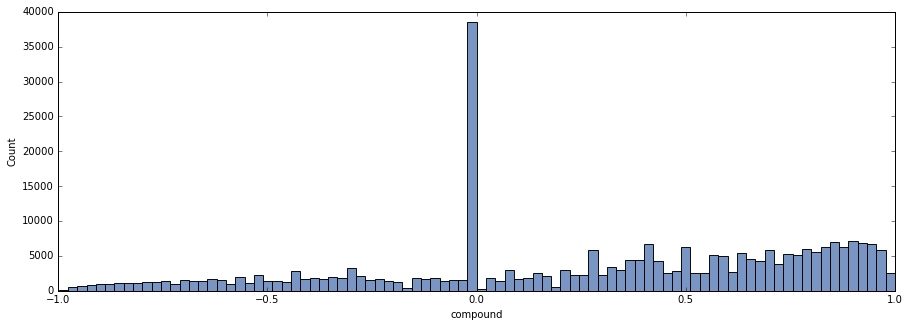

In [181]:
f,x = plt.subplots(1,1,figsize=(15,5))

sns.histplot(data=df, x='compound')

## Yearly observations

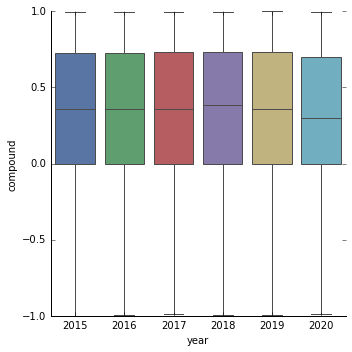

In [182]:
sns.catplot(x="year", y="compound", kind="box", data=df)

Text(0.5, 1.0, 'Average polarity score over the years')

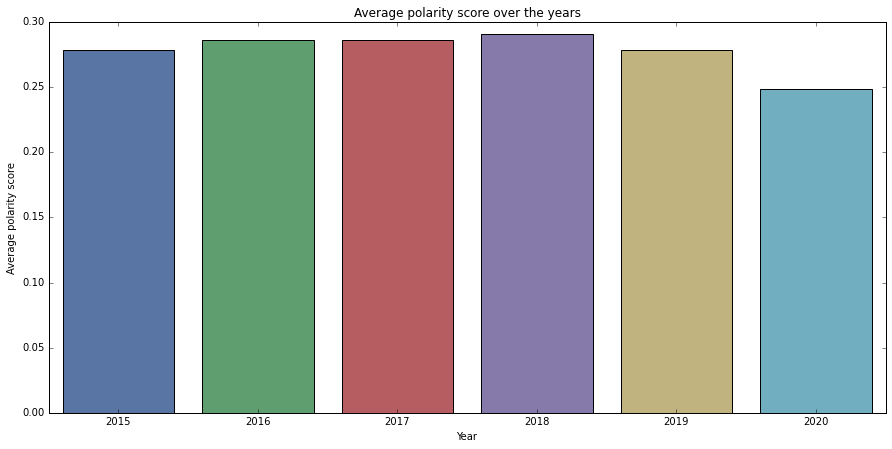

In [183]:
avg_scores = df.compound.groupby(by=df.year).mean()



g =sns.barplot(x=df.year.cat.categories, y=avg_scores)

g.set_xlabel("Year")
g.set_ylabel("Average polarity score")
g.set_title("Average polarity score over the years")

## Monthly category

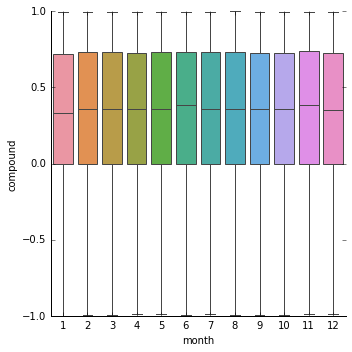

In [184]:
sns.catplot(x="month", y="compound", kind="box", data=df)

Text(0.5, 1.0, 'Average polarity score over the months')

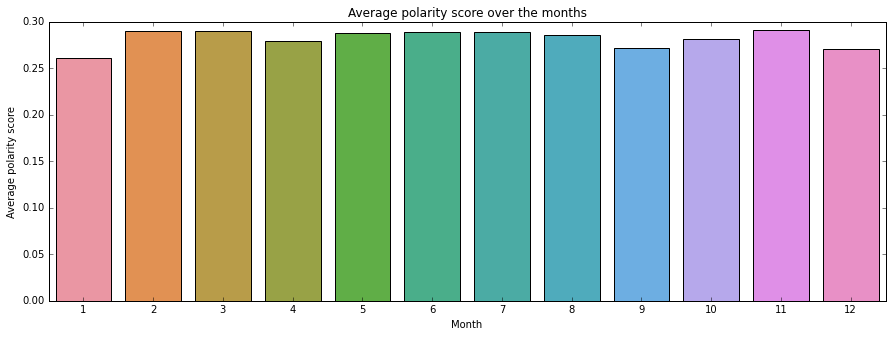

In [185]:
avg_scores = df.compound.groupby(by=df.month).mean()

f,x = plt.subplots(1,1,figsize=(15,5))

g =sns.barplot(x=df.month.cat.categories, y=avg_scores)

g.set_xlabel("Month")
g.set_ylabel("Average polarity score")
g.set_title("Average polarity score over the months")

## Yearly-monthly category

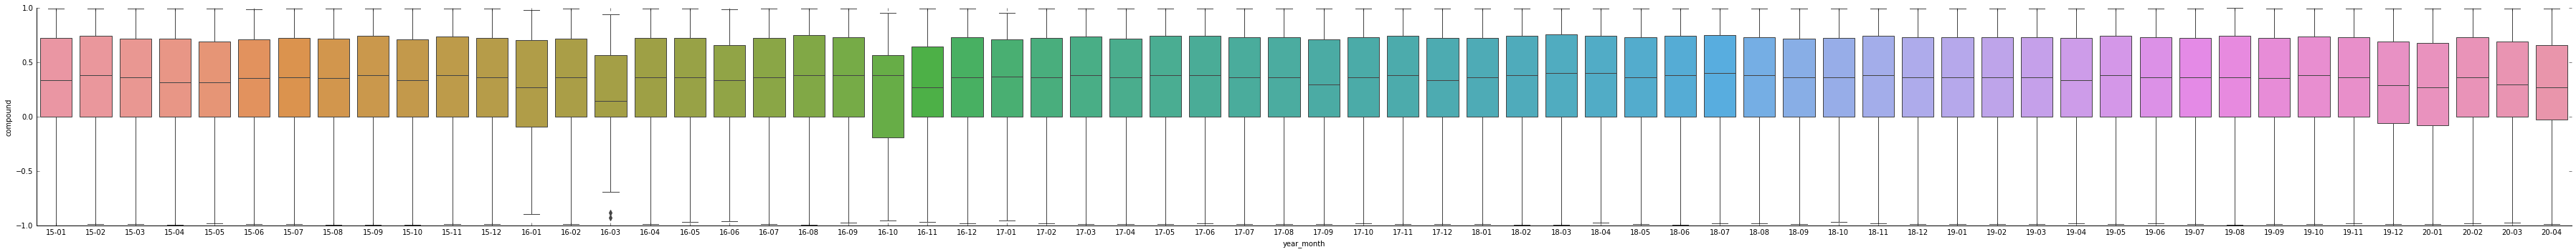

In [186]:
sns.catplot(x="year_month", y="compound", kind="box", data=df,height=5,aspect=10)

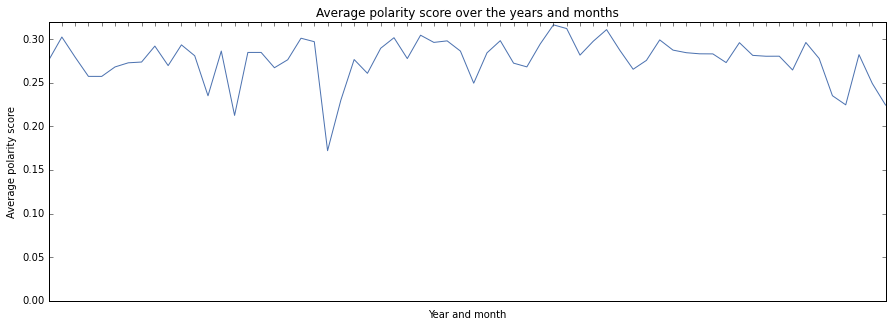

In [188]:
avg_scores = df.compound.groupby(by=df.year_month).mean()

f,x = plt.subplots(1,1,figsize=(15,5))

g =sns.lineplot(x=df.year_month.cat.categories, y=avg_scores)

g.set_xlabel("Year and month")
g.set_ylabel("Average polarity score")
g.set(xticklabels=[])
g.set_title("Average polarity score over the years and months")
g.set_ylim(0)
g.tick_params(bottom=False)

We notice a dip in November 2016

## Yearly-monthly-daily category

C:\Users\Harold\AppData\Local\Temp/ipykernel_14312/3798919641.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(xticklabels=ticks_labels)


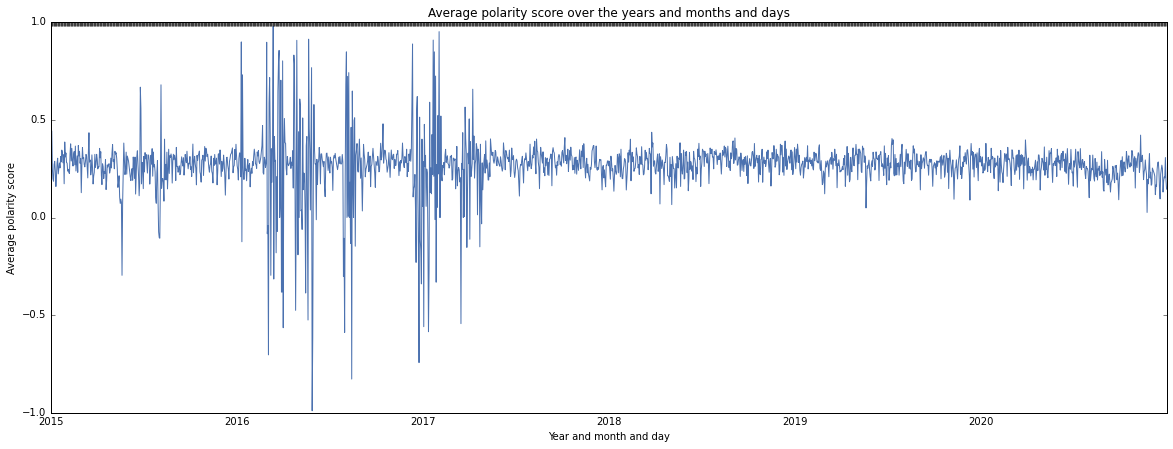

In [189]:
avg_scores = df.compound.groupby(by=df.year_month_day).mean()

f,x = plt.subplots(1,1,figsize=(20,7))

g =sns.lineplot(x=avg_scores.index, y=avg_scores)
length = len(avg_scores)
years= [2015,2016,2017,2018,2019,2020]
step = length// len(years)
ticks_labels= [years[i // step] if (i%step == 0 and i // step < 6) else "" for i in range(length)]

g.set_xlabel("Year and month and day")
g.set_ylabel("Average polarity score")
g.set(xticklabels=ticks_labels)
g.set_title("Average polarity score over the years and months and days")
g.tick_params(bottom=False) 


Looking at this, it seems like that the narrative hasn't been increasingly polarized but it has know periods with very high polarity, let us investiage those time periods.

C:\Users\Harold\AppData\Local\Temp/ipykernel_14312/3642520798.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(xticklabels=ticks_labels)


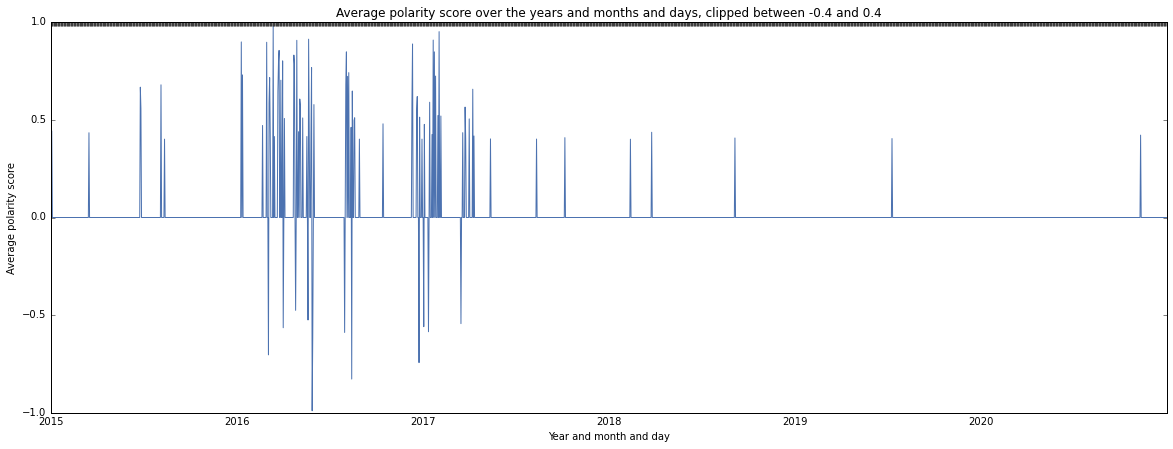

In [190]:
test = avg_scores[:].copy()
test[(test < 0.4) & (test > -0.4)] = 0

f,x = plt.subplots(1,1,figsize=(20,7))

g =sns.lineplot(x=avg_scores.index, y= test)
length = len(avg_scores)
years= [2015,2016,2017,2018,2019,2020]
step = length// len(years)
ticks_labels= [years[i // step] if (i%step == 0 and i // step < 6) else "" for i in range(length)]

g.set_xlabel("Year and month and day")
g.set_ylabel("Average polarity score")
g.set(xticklabels=ticks_labels)
g.set_title("Average polarity score over the years and months and days, clipped between -0.4 and 0.4")
g.tick_params(bottom=False) 

In [147]:
## finding the periods with the highest polarity scores

sorted_scores = avg_scores.sort_values()

In [148]:
# let's find the top 5 periods of high polartiy in both directions

k = 5

for i in range(k):
    print(f"Date:{sorted_scores.index[i]} Polarity score: {sorted_scores[i]}\n")

for i in range(k):
    print(f"Date:{sorted_scores.index[-(i+1)]} Polarity score: {sorted_scores[-(i+1)]}\n")

Date:16-04-09 Polarity score: -0.9895

Date:16-06-20 Polarity score: -0.8271

Date:16-10-16 Polarity score: -0.743

Date:16-01-06 Polarity score: -0.7033

Date:16-04-10 Polarity score: -0.6124

Date:16-01-19 Polarity score: 0.9789

Date:16-11-24 Polarity score: 0.95165

Date:16-04-02 Polarity score: 0.913

Date:16-11-13 Polarity score: 0.90855

Date:16-03-06 Polarity score: 0.9072



It looks like 2016 is the period with the highest polarization around climate change. This could be linked with the 2016 USA Election which was highly polarized.

## Examining seasonality and trend via time series analysis

In [149]:
from statsmodels.tsa.seasonal import seasonal_decompose

test = avg_scores.reset_index()

result = seasonal_decompose(test.compound, model='additive',period=length//(12*6))

## Analysis on particular subjects